In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray
import numpy as np
import skimage
from skimage import filters
from skimage.feature import hog
from skimage import exposure
import os
import glob

def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

paths = ["data/cloudy", "data/desert", "data/green_area", "data/water"]
histograms = []

labels = []

for path in paths:
    for file in glob.glob(os.path.join(path, "*.jpg")):
        img = Image.open(file).convert("RGB")
        grscale = rgb2gray(img)
        angle_sobel = angle(filters.sobel_h(grscale), filters.sobel_v(grscale))
        hist, bin_centers = exposure.histogram(angle_sobel, nbins=36)
        histograms.append(hist)
        labels.append(path)
        
histograms = np.array(histograms)
labels = np.array(labels)

print(histograms.shape)
print(labels.shape)

(5631, 36)
(5631,)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#when doing part 6 i remember seeing a stratification param at the train test split documentation, going to try with the flag on
X_train, X_test, y_train, y_test = train_test_split(
    histograms, labels, test_size=0.20, random_state=42, stratify=labels)

#sanity check so that I know there arent int values
X_train = X_train.astype(np.float64)
X_test  = X_test.astype(np.float64)


scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

#transform still using means/std from fit around train set
X_test = scaler.transform(X_test)


Sources for method calls:
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    
https://scikit-learn.org/stable/modules/preprocessing.html
    

Gaussian Naive Bayes Cross Validation Accuracy =  0.9480461215932914
Gaussian Naive Bayes Accuracy and F1 =  0.9574090505767524 0.9590579543639475


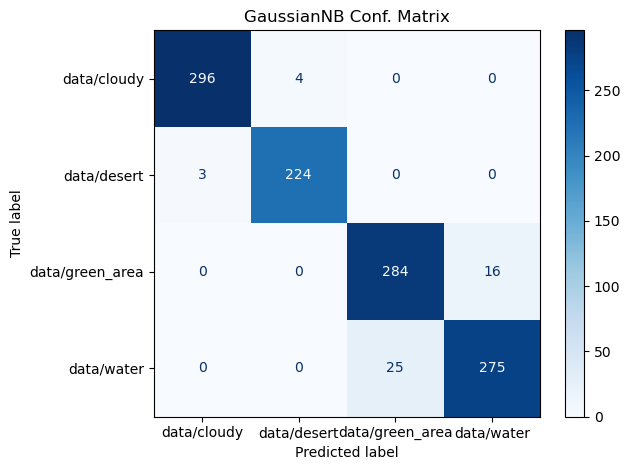

Decision Tree Cross Validation Accuracy =  0.9396100628930817
Decision Tree Accuracy and F1 =  0.9343389529724934 0.9377811486222106


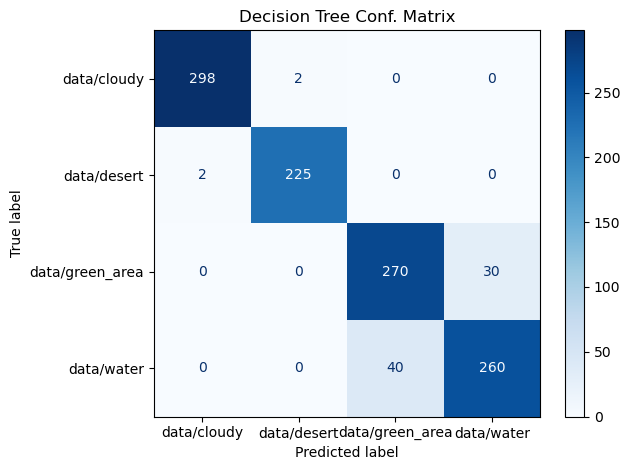

Random Forest Tree Cross Validation Accuracy =  0.9631451473671231
Random Forest Tree Accuracy and F1 =  0.9680567879325643 0.9698654025571949


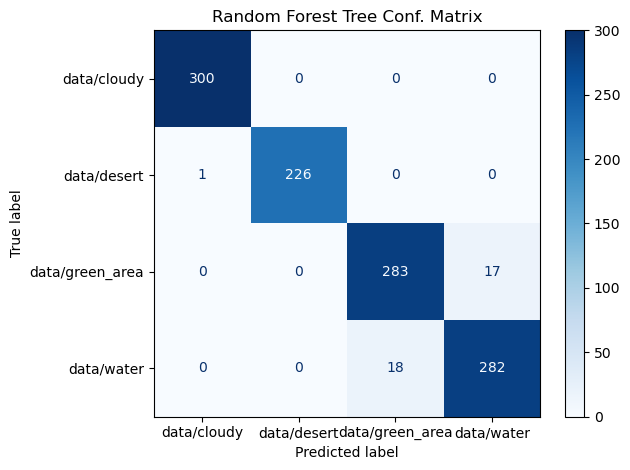

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score

validator = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
#Naive Bayes 
GNB = GaussianNB()

GNBcrsval = cross_validate(GNB, X_train, y_train, cv=validator, scoring=["accuracy"])

GNBcrsAcc = GNBcrsval["test_accuracy"].mean()

print("Gaussian Naive Bayes Cross Validation Accuracy = " , GNBcrsAcc)

GNB_final = GaussianNB().fit(X_train, y_train)
GNB_y_pred = GNB_final.predict(X_test)

gnb_acc = accuracy_score(y_test, GNB_y_pred)
#pretty sure I can use macro as an average measure here because 
#there is almost no probability of class imbalance because of the 
#size of the classes
gnb_f1  = f1_score(y_test, GNB_y_pred, average="macro")

print("Gaussian Naive Bayes Accuracy and F1 = " , gnb_acc, gnb_f1)

#need class names otherwise labels are index by index (creating a n x n matrix where n is over 5000)
class_names = ["data/cloudy", "data/desert", "data/green_area", "data/water"]
ConfusionMatrixDisplay.from_predictions(
    y_test, GNB_y_pred,
    labels=class_names,
    display_labels=class_names,
    cmap="Blues"
)
plt.title("GaussianNB Conf. Matrix")
plt.tight_layout()
plt.show()

#Decision Trees

DTC = DecisionTreeClassifier()
DTCcrsval = cross_validate(DTC, X_train, y_train, cv=validator, scoring=["accuracy"])

DTCcrsAcc = DTCcrsval["test_accuracy"].mean()

print("Decision Tree Cross Validation Accuracy = ", DTCcrsAcc)

DTC_final = DTC.fit(X_train, y_train)
DTC_y_pred = DTC_final.predict(X_test)

dt_acc = accuracy_score(y_test, DTC_y_pred)
dt_f1  = f1_score(y_test, DTC_y_pred, average="macro")

print("Decision Tree Accuracy and F1 = " , dt_acc, dt_f1)

ConfusionMatrixDisplay.from_predictions(
    y_test, DTC_y_pred,
    labels=class_names,
    display_labels=class_names,
    cmap="Blues"
)
plt.title("Decision Tree Conf. Matrix")
plt.tight_layout()
plt.show()

#RF Trees

RF = RandomForestClassifier()
RFcrsval = cross_validate(RF, X_train, y_train, cv=validator, scoring=["accuracy"])

RFcrsAcc = RFcrsval["test_accuracy"].mean()

print("Random Forest Tree Cross Validation Accuracy = " , RFcrsAcc)

RF_final = RF.fit(X_train, y_train)
RF_y_pred = RF.predict(X_test)

rf_acc = accuracy_score(y_test, RF_y_pred)
rf_f1  = f1_score(y_test, RF_y_pred, average="macro")

print("Random Forest Tree Accuracy and F1 = " , rf_acc, rf_f1)

ConfusionMatrixDisplay.from_predictions(
    y_test, RF_y_pred,
    labels=class_names,
    display_labels=class_names,
    cmap="Blues"
)
plt.title("Random Forest Tree Conf. Matrix")
plt.tight_layout()
plt.show()

Sources for this section:

Cross Validation:

    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    
    https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/
    
    https://scikit-learn.org/stable/modules/cross_validation.html#stratification
    
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html 
    
    https://scikit-learn.org/stable/modules/preprocessing.html#
    
    https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring
    
Gaussian NB:
    https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
    
https://scikit-learn.org/stable/common_pitfalls.html#

Conf. Matrix:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html 

Other:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

6a. For the most part each method is pretty good, but the one that visually is the best is the random forest tree classifier. this is because it has the smallest amount of values that were misclassified

6b. above it can be seen that the method with the highest accuracy is the Random Forest Tree, it is important to note that this is also when it is running with the default number of estimators which is 100

6c/6d. again both of the best accuracy and f1 scores come from the random forest tree classifier

In [4]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold

new_classes = ["data/cloudy", "data/desert"]
train_filter = np.isin(y_train, new_classes)
X_train_new = X_train[train_filter]
y_train_new = y_train[train_filter]

kFold = KFold(n_splits=5, shuffle=True, random_state=42)
strat = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

cSet = [0.1, 1, 10, 100]
t_error_kFold = []
v_error_kFold = []
t_error_strat = []
v_error_strat = []


for C in cSet:
    SVC = LinearSVC(C=C)
    SVCcrsval = cross_validate(SVC, X_train_new, y_train_new, cv=kFold, scoring=["accuracy"], return_train_score=True)
    #making return train score for error later (#7 point 1)
    SVCcrsAccKFold = SVCcrsval["train_accuracy"].mean()
    SVCcrsTestKFold = SVCcrsval["test_accuracy"].mean()
    
    t_error_kFold.append((1-SVCcrsAccKFold) * 100)
    v_error_kFold.append((1-SVCcrsTestKFold) * 100)
    
    SVCcrsval = cross_validate(SVC, X_train_new, y_train_new, cv=strat, scoring=["accuracy"], return_train_score=True)
    
    SVCcrsAccStrat = SVCcrsval["train_accuracy"].mean()
    SVCcrsTestStrat = SVCcrsval["test_accuracy"].mean()
    
    t_error_strat.append((1-SVCcrsAccStrat) * 100)
    v_error_strat.append((1-SVCcrsTestStrat) * 100)
    
    print(f"C={C}: KFold val acc={SVCcrsTestKFold:.4f}, Stratified val acc={SVCcrsTestStrat:.4f}")

    #print("Support Vector Cross Validation Accuracy = ", DTCcrsAcc)

C=0.1: KFold val acc=0.9948, Stratified val acc=0.9948
C=1: KFold val acc=0.9976, Stratified val acc=0.9981
C=10: KFold val acc=0.9981, Stratified val acc=0.9981
C=100: KFold val acc=0.9976, Stratified val acc=0.9986


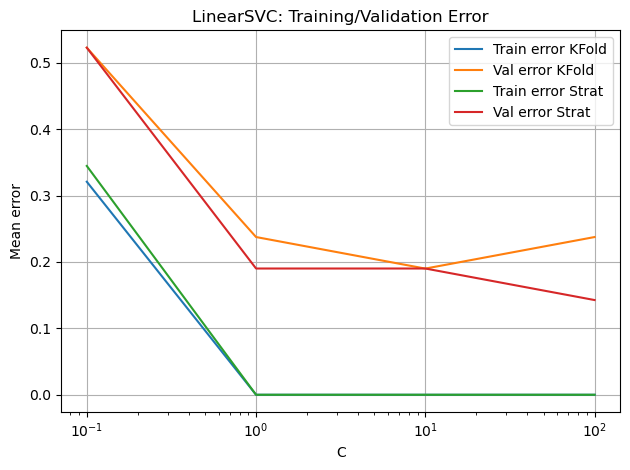

In [5]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(cSet, t_error_kFold, label="Train error KFold")
plt.plot(cSet, v_error_kFold, label="Val error KFold")
plt.plot(cSet, t_error_strat, label="Train error Strat")
plt.plot(cSet, v_error_strat, label="Val error Strat")

#looks horrible without scaling x axis in some way
plt.xscale("log")  
plt.xlabel("C")
plt.ylabel("Mean error")
plt.title("LinearSVC: Training/Validation Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

It can be seen from my output above that lowest mean error for each curve is as follows:

KFold Training: C = 1

Kfold Validation: C = 10

StratifiedTraining: C = 1 

Stratified Validation: C = 100

It can also be inferred that the complexity of the model increases in relation to C

I think there is some underfitting specifically at c=0.1 but i think that can be expected with a dataset of this size
I also feel like there is definitely a degree of overfitting to the model, I mainy see this in the training error dropping to 1 as soon as the number of classes becomes 1 and the validation error drops relative to the drop in training error but after that there is very little reduction in error, even more interestingly the error in the non-stratified kfold increases when the number of classes goes from 10 to 100.

Sources on SVM context:
    https://scikit-learn.org/stable/modules/svm.html


In [6]:
best = int(np.argmin(v_error_strat))
best_C = cSet[best]
print("Best C strat =", best_C)
print("Mean stratified val error at best C = " ,v_error_strat[best])

test_filter = np.isin(y_test, new_classes)
X_test_new = X_test[test_filter]    
y_test_new = y_test[test_filter]

best_svc = LinearSVC(C=best_C)
best_svc.fit(X_train_new, y_train_new)

y_test_pred = best_svc.predict(X_test_new)
test_acc = accuracy_score(y_test_new, y_test_pred)
test_err = (1 - test_acc) * 100

print("Test accuracy with best C = ",test_acc)
print("Test error with best C = ", test_err)

Best C strat = 100
Mean stratified val error at best C =  0.142630924103615
Test accuracy with best C =  1.0
Test error with best C =  0.0
